## Setup calour

In [1]:
import calour as ca
%matplotlib notebook

/Users/amnon/miniconda3/envs/calour/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load the American Gut dataset
using the December 14, 2016 demultiplexed reads fasta file from Ameican Gut (ftp://ftp.microbio.me/AmericanGut/)

We set log level to critical before loading since otherwise we get lots of warnings about missing samples (i.e. in mapping file but not in biom table)

Note the biom table is filtered for blooming bacteria (see Correcting for Microbial Blooms in Fecal Samples during Room-Temperature Shipping, Amir at al. 2017)

In [2]:
ca.set_log_level('CRITICAL')
dat=ca.read_amplicon('./ag.150.min10.16s.nobloom.withtax.biom','map.txt',normalize=10000,min_reads=1000)
ca.set_log_level('INFO')

# Divide to skin, feces and saliva samples

In [3]:
fec=dat.filter_samples('BODY_PRODUCT','UBERON:feces')
sal=dat.filter_samples('BODY_PRODUCT','UBERON:saliva')
skin=dat.filter_samples('BODY_PRODUCT','UBERON:sebum')

In [4]:
del dat

## Cluster bacteria by similar behavior

In [5]:
skinc=skin.cluster_features(min_abundance=10)

2018-07-12 17:23:50 INFO After filtering, 5430 remaining


## Add dbBact terms (out of 'feces','saliva','skin')
By default it is added as common_term column in feature_metadata

In [9]:
skinc.add_terms_to_features('dbbact',['feces','saliva','skin'], ignore_exp=[63])

AmpliconExperiment ("ag.150.min10.16s.nobloom.withtax.biom") with 347 samples, 5430 features

In [10]:
skinc.feature_metadata.common_term.value_counts()

NA        1471
other     1443
feces     1003
skin      1002
saliva     511
Name: common_term, dtype: int64

In [11]:
skinc.feature_metadata.common_term = ['other' if i=='NA' else i for i in skinc.feature_metadata.common_term]

In [12]:
skinc

AmpliconExperiment ("ag.150.min10.16s.nobloom.withtax.biom") with 347 samples, 5430 features

## plot all bacteria (fig S3-A)
We also use this figure to interactively look for interesting clusters, and store their coordinates using "print axes ranges" button

<IPython.core.display.Javascript object>


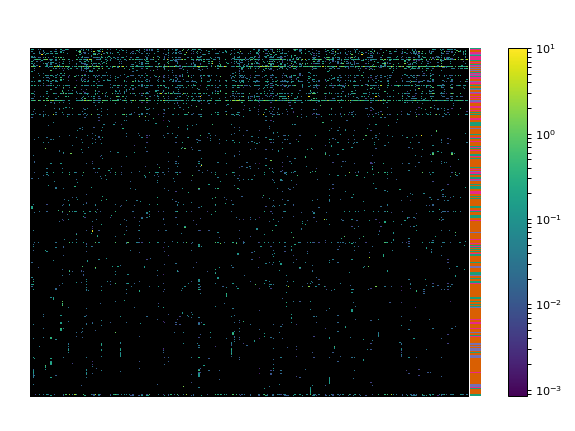

In [13]:
f=skinc.normalize(100).plot(gui='jupyter',
                            bary_fields=['common_term'],
                            bary_label=False,
                            feature_field=None,
                            clim=[0,10])

In [14]:
f.save_figure('figure-S3A-ag-skin-all.pdf')

## plot skin cluster bacteria (fig S3-B)

<IPython.core.display.Javascript object>


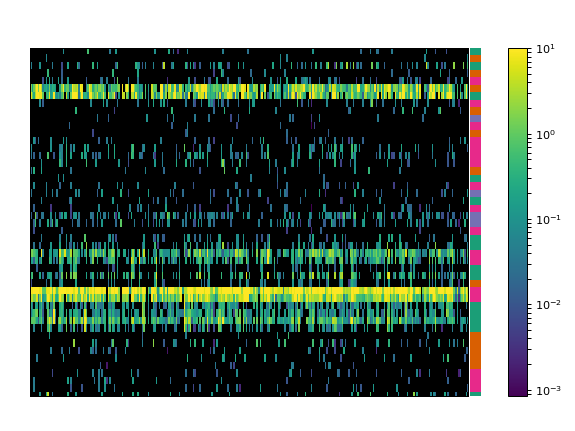

In [15]:
f=skinc.normalize(100).plot(gui='jupyter',bary_fields=['common_term'],bary_label=False,
                            clim=[0,10],feature_field=None,
                            rect=[-0.5, 282.5, 307.05859375, 260.63671875])

In [ ]:
f.save_figure('figure-S3B-ag-skin-cluster-skin.pdf')

## plot saliva cluster bacteria (fig S3-C)

In [ ]:
f=skinc.normalize(100).plot(gui='jupyter',bary_fields=['common_term'],
                            bary_label=False,feature_field=None,
                            rect=[-0.5, 346.5, 840, 790],clim=[0,10])

In [ ]:
f.save_figure('figure-S3C-ag-skin-saliva-cluster.pdf')

## plot the cluster to save the cluster bacteria to fasta file ("ag-skin-saliva-cluster.fa")
After marking them in the figure

In [ ]:
skinc.normalize(100).plot(gui='qt5',bary_fields=['common_term'],bary_label=False,
                          feature_field=None,
                          rect=[-0.5, 346.5, 840, 790],clim=[0,10])

# plot the taxa plot (Fig. S3-D)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
zz=skin.filter_fasta('./ag-skin-saliva-cluster.fa')

In [ ]:
f = plt.figure()
zzz=zz.collapse_taxonomy()
zzz=zzz.sort_abundance(key=np.mean)
freq=[]
tax=[]
allmean = zzz.data.mean(axis=0)
for idx,cbact in enumerate(zzz.feature_metadata.index.values):
    ctax = zzz.feature_metadata.taxonomy[cbact].split(';')
    ctax = ';'.join(ctax[-2:])
    tax.append(ctax)
    freq.append(allmean[idx]/100)
plt.barh(np.arange(len(freq)),freq,align='center')
plt.xscale('log')
plt.yticks(np.arange(len(freq)),tax)
plt.tight_layout()

In [ ]:
f.savefig('figure-S3D-ag-skin-saliva-cluster-taxonomy.pdf')

## Find dbBact enriched terms for the saliva bacteria cluster compared to the rest of the bacteria in the experiment (Fig. S3-E)

In [ ]:
res=skinc.enrichment(zz.feature_metadata.index.values,'dbbact')

In [ ]:
f=skinc.plot_enrichment(res,max_len=40)

In [ ]:
f.figure.savefig('figure-S3E-ag-skin-saliva-cluster-terms.pdf')